In [ ]:
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import sys
from pathlib import Path
import time

# get project directory
path = Path.cwd().parent.parent

# import configuration and functions modules
sys.path.append(str(path.parent / 'common_data'))
import my_config as my_config
sys.path.append(str(path.parent / 'my_module'))
import my_module as mm

sys.path.append(str(path / 'source/1_ell_values'))
import ell_values_GUT as ell_utils

sys.path.append(str(path / 'source/2_matrici_base'))
import matrici_base_v53_SSCprove_GUT_noSEYF as Cl_utils

sys.path.append(str(path / 'source/3_covmat'))
import cov_v95_SSCprove_GUT_more_general as covmat_utils

sys.path.append(str(path / 'source/4_FM'))
import FM_v98_SSCprove_GUT_forISTNL as FM_utils

sys.path.append(str(path / 'source/5_plots/plot_FM'))
import plots_FM_v106_SSCprove_GUT_noCLOE as plot_utils

In [12]:
start_time = time.perf_counter()

params = {'lines.linewidth' : 3.5,
          'font.size' : 20,
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large',
          'mathtext.fontset': 'stix',
          'font.family': 'STIXGeneral',
          'figure.figsize': [12, 12]
          }
plt.rcParams.update(params)
markersize = 10

In [ ]:
survey_area = 15000 # deg^2
deg2_in_sphere = 41252.96 # deg^2 in a spere
fsky_IST = survey_area/deg2_in_sphere
fsky_syvain = 0.375 

general_settings = {
    'ell_min': 10,
    'ell_max_WL': 5000,
    'ell_max_GC': 5000,
    'zbins': 10,
    'nProbes': 2,
    'nbl': 20,
    'which_forecast': 'IST',
    'Cij_folder': 'Cl_CLOE'
    }

cov_settings = {
    'ind_ordering': 'CLOE',
    'GL_or_LG': 'LG',
    'save_SSC_only_covmats': False,
    'compute_covariance_in_blocks': False,
    'fsky': fsky_IST,
    'Rl': 4
    }

FM_settings = {
    'nParams': 20,
    'save_npy': False
    }

plot_settings = {
    'case': 'opt',
    'probe': '3x2pt',
    'SSC_flag': 'G',
    'covmat_dav_flag': 'no',
    'which_plot': 'constraints_only'
    }

In [ ]:
Sijkl = np.load(path.parent / "common_data/Sijkl/Sijkl_WFdavide_nz10000_IA_3may.npy") # WFdavide nz 10000

In [ ]:
# import Santiago's Cl
C_LL_2D = np.genfromtxt(path / 'data/Cl_CLOE/Cls_zNLA_ShearShear_NL_flag_2.dat')
C_GL_2D = np.genfromtxt(path / 'data/Cl_CLOE/Cls_zNLA_PosShear_NL_flag_2.dat')
C_GG_2D = np.genfromtxt(path / 'data/Cl_CLOE/Cls_zNLA_PosPos_NL_flag_2.dat')

# remove ell column
C_LL_2D = C_LL_2D[:,1:]
C_GL_2D = C_GL_2D[:,1:]
C_GG_2D = C_GG_2D[:,1:]

In [ ]:
ell_bins = np.linspace(np.log(10.), np.log(5000.), 21)
ells = (ell_bins[:-1]+ell_bins[1:])/2.
ells = np.exp(ells)

deltas = np.diff(np.exp(ell_bins))

nbl = ells.size


ell_dict = {
    'ell_WL': ells,
    'ell_GC': ells}
delta_dict = {
    'delta_l_WL': deltas,
    'delta_l_GC': deltas}
Cl_dict_2D = {
    'C_LL_2D': C_LL_2D,
    'C_GL_2D': C_GL_2D,
    'C_GG_2D': C_GG_2D}

In [ ]:
# reshape the Cls in (nbl, zbins, zbins)
Cl_dict = Cl_utils.generate_Cls(general_settings, ell_dict, Cl_dict_2D)

# compute covariance
cov_dict = covmat_utils.compute_cov(general_settings, cov_settings, ell_dict, delta_dict, Cl_dict, Sijkl)

## 3x2pt covariance matrix 2D ordering:
Davide vs "Santiago" (files found in `likelihood-implementation/data/ExternalBenchmark/Photometric/data` folder) 

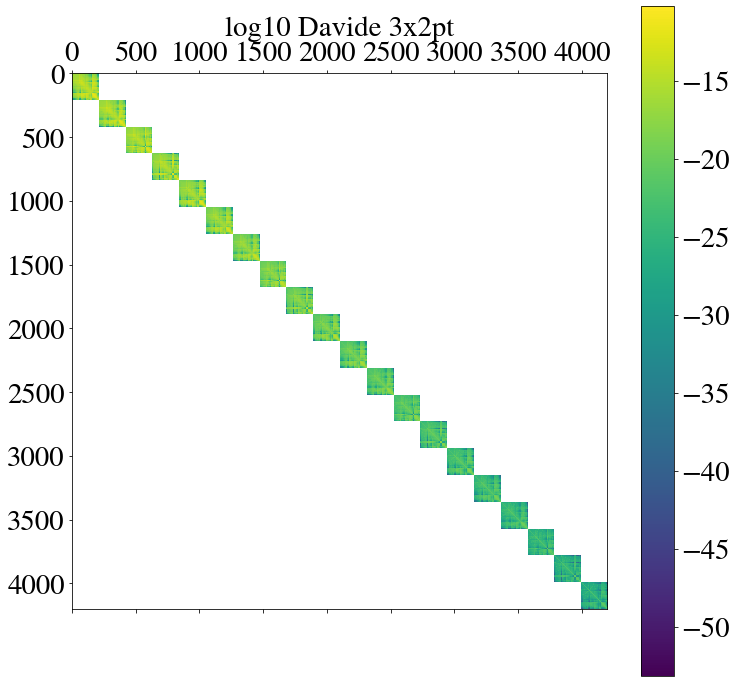

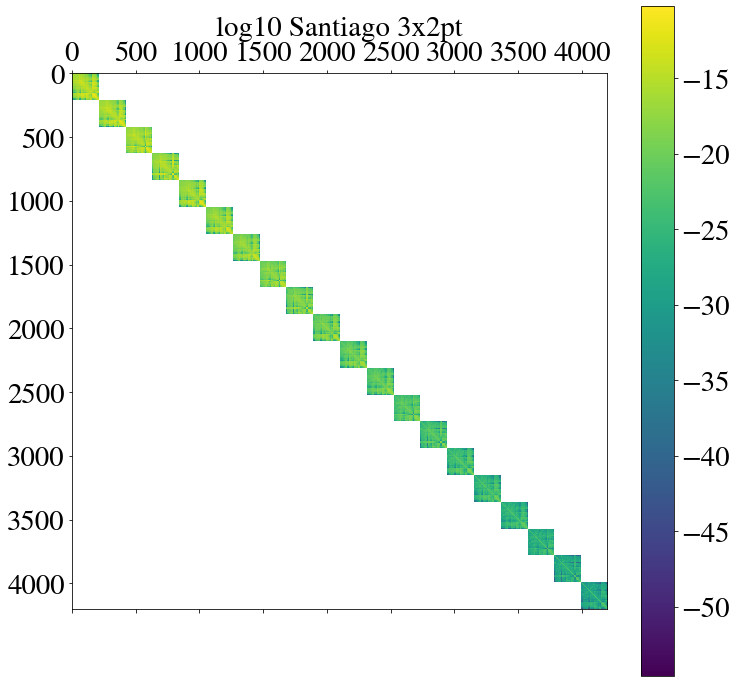

In [17]:
# some tests
# import CLOE's covariance (from 'likelihood-implementation/data/ExternalBenchmark/Photometric/data' folder)
cov_WL_benchmark = np.load('/Users/davide/likelihood-implementation/data/ExternalBenchmark/Photometric/data/CovMat-ShearShear-Gauss-20Bins.npy')
cov_GC_benchmark = np.load('/Users/davide/likelihood-implementation/data/ExternalBenchmark/Photometric/data/CovMat-PosPos-Gauss-20Bins.npy')
cov_3x2pt_benchmark = np.load('/Users/davide/likelihood-implementation/data/ExternalBenchmark/Photometric/data/CovMat-3x2pt-Gauss-20Bins.npy')

# my covariance, using different reshaping conventions
cov_d_2DCLOE = cov_dict['cov_3x2pt_G_2DCLOE'] # this is the reshaping I thought CLOE is using
cov_d_4D = cov_dict['cov_3x2pt_G_4D']
cov_d_2D = cov_dict['cov_3x2pt_G_2D'] # this is the reshaping I was using in my code, which coincides with the benchmark data


cov_d = cov_d_2D
cov_s = cov_3x2pt_benchmark

mm.matshow(np.abs(cov_d), 'Davide 3x2pt', log=True)
mm.matshow(np.abs(cov_s), 'Santiago 3x2pt', log=True)

This looks promising; however, this is what I thought was CLOE's 2D reshaping: see next image for an explanation of the ordering (if needed)

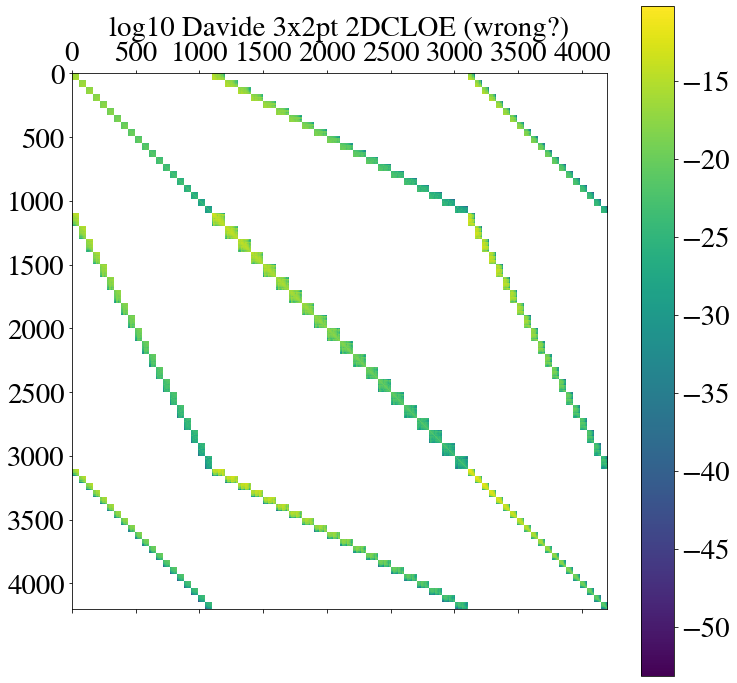

In [18]:
mm.matshow(np.abs(cov_d_2DCLOE), 'Davide 3x2pt 2DCLOE (wrong?)', log=True)

The blocks on the different diagonals are parts of the blocks of the above matrix (the one with only one diagonal); for example, the 1st 1100x1100 block (upper left) has on its diagonal (55x55) arrays which are the upper left part of each 210x210 block in the previous plot (a picture is really woth a thousand words, in this case)...

![alt text](ordering_comparison.png "Title")

So, the question is: which 2D convention should we use? \
Plus, I have encountered a couple other issues:
* the agreement between my covmat and CLOE's worsens descending the diagonal, which means that it worsens with increasing $\ell$ bin; are the covariance matrices I'm using as benchmark computed with the $\ell$ and $\Delta \ell$ values as the ones found in the script (I re-write the algorithm in the follong cell)?
* I obtain good agreement when using the indices' ordering corresponding to $C_\ell^{XC} = C_\ell^{LG}$, but from the naming of the files it looks more like it's $C_\ell^{XC} = C_\ell^{GL}$. Maybe the 3x2pt covariance is build from the datavector (LL, LG, GG)? Of course there is no problem in this, I just thought the XC element of the datavector would be the same as the Cl provided and I wanted to make sure to know which convention is being used.

In [26]:
ell_bins = np.linspace(np.log(10.), np.log(5000.), 21)
ells = (ell_bins[:-1]+ell_bins[1:])/2.
ells = np.exp(ells)

deltas = np.diff(np.exp(ell_bins))

print('ells = \n', ells)
print('\ndeltas = \n', deltas)

ells = 
 [  11.68084471   15.93759367   21.74559276   29.6701506    40.48258636
   55.23530433   75.36422742  102.82855943  140.30147985  191.43033179
  261.19162796  356.37542849  486.24623623  663.4447365   905.21814998
 1235.09895242 1685.19535574 2299.31648913 3137.23646293 4280.51234829]

deltas = 
 [   3.6442133     4.97224236    6.78423354    9.25655295   12.62983829
   17.23242076   23.51228246   32.08065972   43.77153641   59.72281794
   81.4870867   111.18271925  151.7000737   206.98281637  282.41176967
  385.32864247  525.75061897  717.34535895  978.76130895 1335.44280723]
